In [1]:
import sys 
sys.path.append('../')

import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt

from src.dataset import load_mat1d
from src.ops import grid2d_coords
from src.green_net import Grid1D

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Shallow(nn.Module):
    def __init__(self, in_dim , h_dim , out_dim):
        super().__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out

def count_parameters(model, requires_grad = True):
    """Count trainable parameters for a nn.Module."""
    if requires_grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

In [4]:
def loss(model, grid, F, U):
    nh = grid.nh
    h = grid.nh
    G = model(grid.x_hh).reshape(nh, nh)
    U_pred = h*G @ F
    loss = torch.mean((U-U_pred)**2)
    return loss

In [23]:
F_train = load_mat1d('../dataset/f1d_513_3.00e-02.mat', 'F', 100, True)
U_train = load_mat1d('../dataset/logarithm_513_3.00e-02.mat', 'U', 100, True)
F_val = load_mat1d('../dataset/f1d_513_3.00e-02.mat', 'F', 100, False)
U_val = load_mat1d('../dataset/logarithm_513_3.00e-02.mat', 'U', 100, False)

F_train = torch.from_numpy(F_train).float().to(device)
U_train = torch.from_numpy(U_train).float().to(device)
F_val = torch.from_numpy(F_val).float().to(device)
U_val = torch.from_numpy(U_val).float().to(device)

grid = Grid1D(513, device)
grid.init_grid_hh()

In [32]:
model = Shallow(2, 50, 1).to(device)

In [33]:
optimizerLBFGS = torch.optim.LBFGS(
    model.parameters(), 
    lr=1., 
    max_iter=50000, 
    max_eval=50000, 
    history_size=50,
    tolerance_grad=np.finfo(float).eps, 
    tolerance_change=np.finfo(float).eps,
    line_search_fn="strong_wolfe"       # can be "strong_wolfe"
)

In [34]:
def loss_func_lbfgs():
    
    optimizerLBFGS.zero_grad()
    global itera
    itera += 1

    lossLBFGS = loss(model, grid, F_train, U_train)
    lossLBFGS_valid = loss(model, grid, F_val, U_val)

    if itera % 5000 == 0:
        print('Iter %d, LossLBFGS: %.5e' % (itera, lossLBFGS.item()))
    
    savedloss.append(lossLBFGS.item())
    savedloss_valid.append(lossLBFGS_valid.item())
    
    lossLBFGS.backward(retain_graph = True)
    
    return lossLBFGS

In [35]:
itera = 0

savedloss = []
savedloss_valid = []

In [36]:
%%time

model.train()

lossLBFGS = loss(model, grid, F_train, U_train)
lossLBFGS_valid = loss(model, grid, F_val, U_val)

print('Iter %d, LossLBFGS: %.5e' % (itera, lossLBFGS.item()))

savedloss.append(lossLBFGS.item())
savedloss_valid.append(lossLBFGS_valid.item())

# Backward and optimize
optimizerLBFGS.step(loss_func_lbfgs)

Iter 0, LossLBFGS: 5.10819e+08
CPU times: user 421 ms, sys: 54.3 ms, total: 476 ms
Wall time: 527 ms


tensor(5.1082e+08, device='cuda:0', grad_fn=<MeanBackward0>)

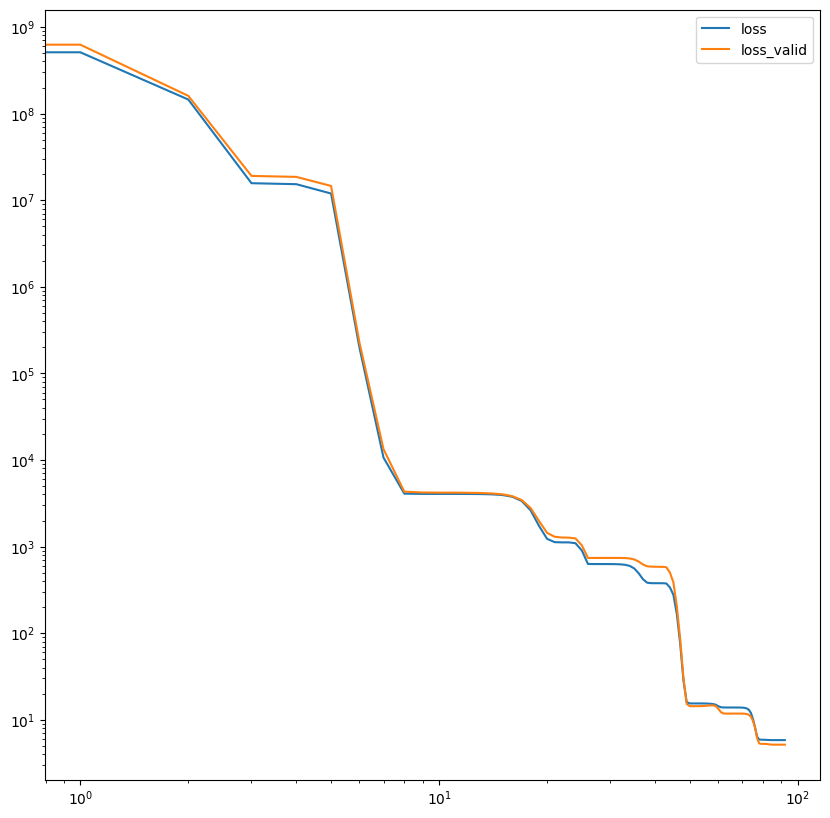

In [37]:
start = 0
end = itera
idx = list(range(start, end, 1))

fig = plt.figure(figsize= (10, 10))
# plt.ylim(10**(-13), 10**(2))
plt.yscale("log")
plt.xscale("log")
plt.plot(idx, savedloss[start:end], label = "loss")
plt.plot(idx, savedloss_valid[start:end], label = "loss_valid")
plt.legend()
plt.show()